In [1]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean, MPI

import gym
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import numpy as np
import matplotlib.pyplot as plt

## Let's Try Bayesian Optimization

#### Make Network

In [2]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

#### set up phase

In [3]:
max_jump = 2.
n_start = 3
deltas = torch.rand(n_start) * 2*max_jump - max_jump
rwrds = torch.zeros(n_start)
for dind, dd in enumerate(deltas):
    rwrds[dind] = env.step(dd.unsqueeze(-1))[1].item()
#     print(dd)


In [4]:
bo = BayesOpt(deltas, rwrds, normalize=False, 
              max_delta=max_jump, acquisition=MPI)


In [5]:
bo.acquisition

<function ntwrk.bayesopt.bayesopt.MPI>

In [6]:
import seaborn as sns
colors = sns.color_palette()
marksize = 12
tick_fs = 14
label_fs = 18
title_fs = 20
test_act = torch.linspace(-max_jump, max_jump)
lwd = 3

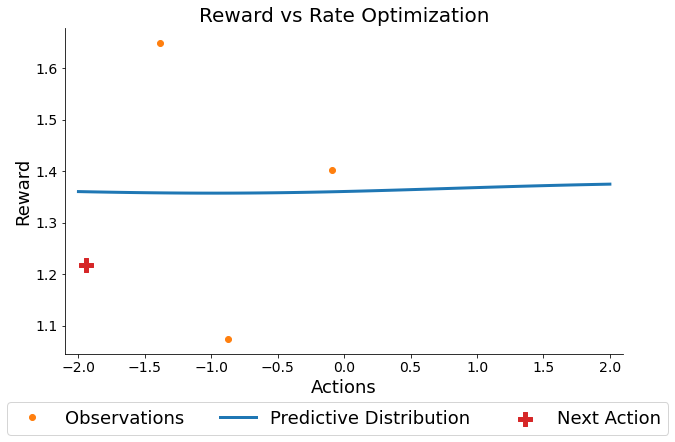

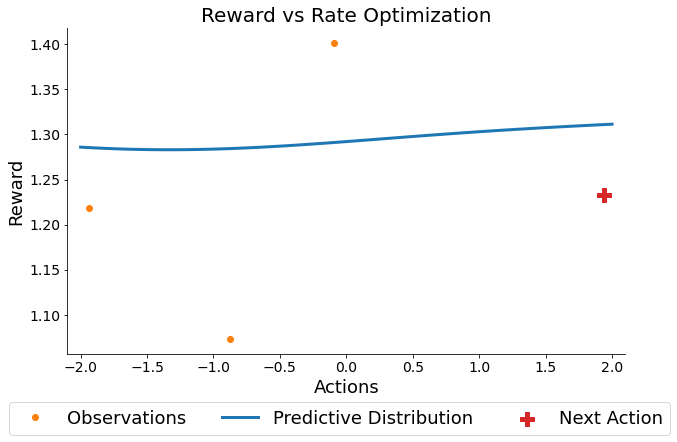

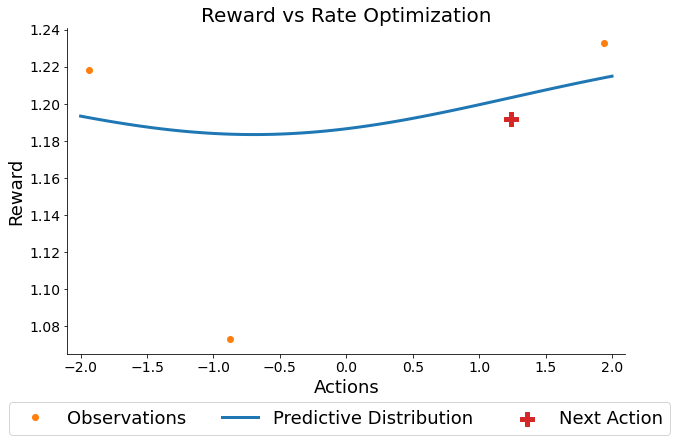

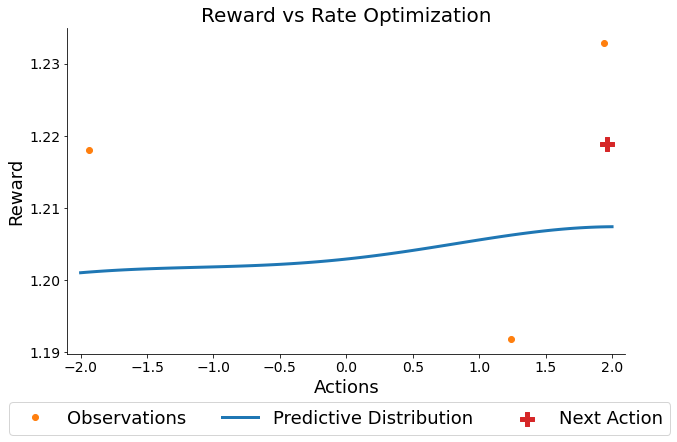

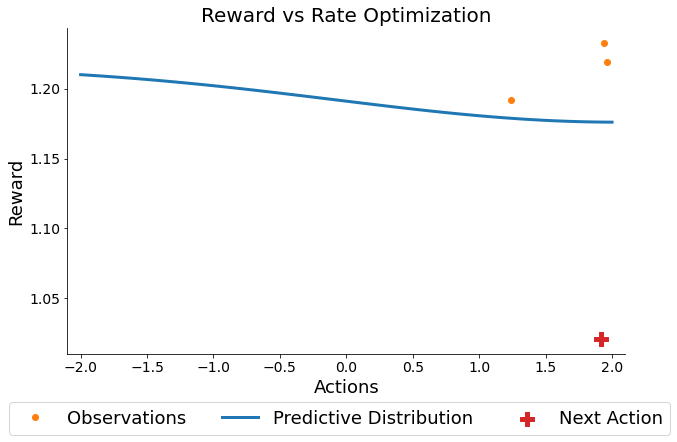

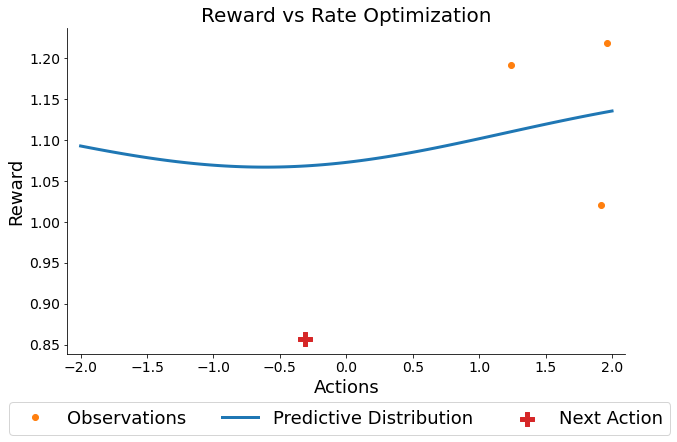

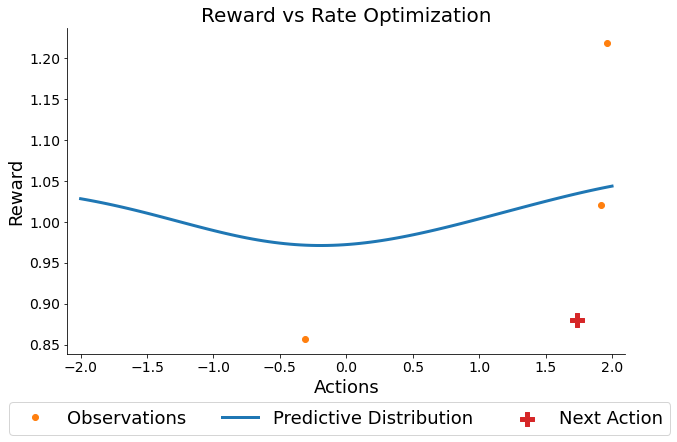

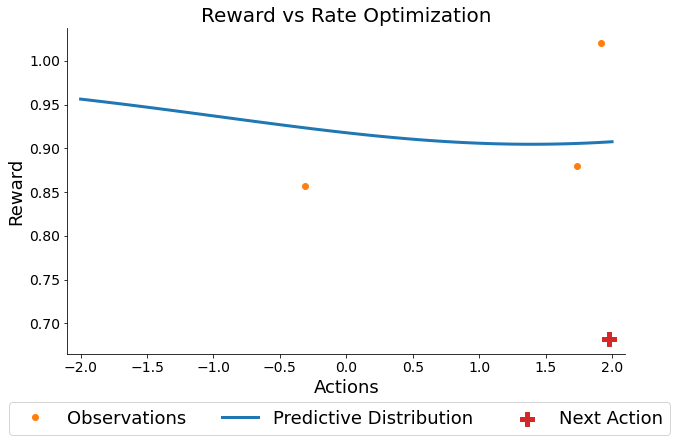

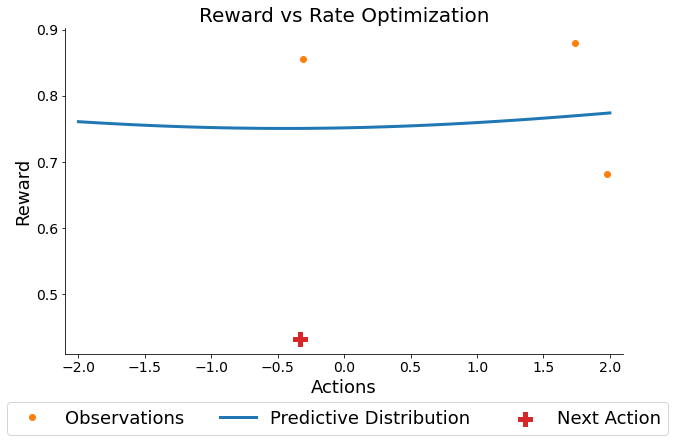

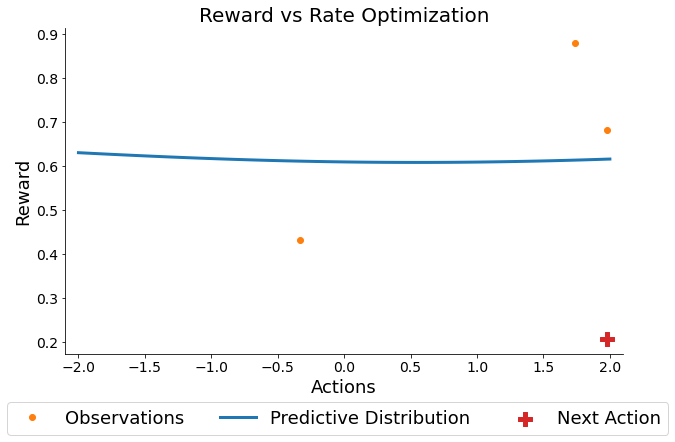

In [7]:
rnds = 10
saved_rwrds = torch.zeros(rnds)
saved_deltas = torch.zeros(rnds)
test_points = torch.linspace(-max_jump, max_jump)
# test_points = torch.arange(1, 1000).float().div(max_x)
for ii in range(rnds):
    bo.train_surrogate(iters=400, overwrite=True)
    next_rate = bo.acquire().unsqueeze(0)
#     print(next_rate.shape)
#     print("next rate = ", next_rate)
    rwrd = torch.tensor(env.step(next_rate)[1]).unsqueeze(0)
    saved_rwrds[ii] = rwrd.item()
#     print(env.senders[0].get_run_data().get("recv rate"))
    bo.update_obs(next_rate, rwrd, max_obs=4)
    
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(bo.train_x[:-1], bo.train_y[:-1], marker=".", linestyle="None",
            label="Observations", color=colors[1], markersize=marksize)

    pred_dist = bo.get_pred_dist(test_act, compute_cov=True)  
    plt.plot(test_points, pred_dist.mean.detach(), label="Predictive Distribution",
            linewidth=lwd)
#     lower, upper = pred_dist.confidence_region()
#     plt.fill_between(test_act, lower.detach(), upper.detach())
#     plt.scatter(rate_history[rnd, -1], rwrd_history[rnd, -1], marker="P",s=200,
#         label="Next Query", linestyle="None", color=colors[2])
    plt.scatter(bo.train_x[-1], bo.train_y[-1], marker='P', s=200,
               color=colors[3], label="Next Action")
    plt.tick_params(labelsize=tick_fs)
    plt.title("Reward vs Rate Optimization", fontsize=title_fs)
    plt.xlabel("Actions", fontsize=label_fs)
    plt.ylabel("Reward", fontsize=label_fs)
    plt.legend(loc='upper left', fontsize=label_fs, bbox_to_anchor=(-0.12, -0.12),
              ncol=3)
    sns.despine()
#     plt.ylim(-1.5, 1.5)
    plt.xlim(-max_jump-0.1, max_jump+0.1)
    plt.show()

In [8]:
saved_rwrds

tensor([1.2181, 1.2329, 1.1917, 1.2189, 1.0204, 0.8564, 0.8802, 0.6816, 0.4312,
        0.2060])